## Part 6 Parameter estimation techniques using MCMC (per band)

Other tutorials
* See also [Hannu's tutorial](https://github.com/hpparvi/exo_tutorials/blob/master/01_broadband_parameter_estimation.ipynb)
* Bayesian and Frequentist Statistics Explained [J. van der Plas blog](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/)
* Data Analysis Recipes: Fitting a model to data ([Hogg et al.](https://arxiv.org/abs/1008.4686))

In [1]:
#check python version
!python --version

Python 3.6.1 :: Continuum Analytics, Inc.


In [2]:
#check environment
import os
os.environ['CONDA_DEFAULT_ENV']

'astroconda35'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

#styling
pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'
fontsize = 18

## import data

In [4]:
from glob import glob

datadir = '.'
path    = os.path.join(datadir,'hatp44_QL*.csv')
file_list = glob(path)
file_list = sorted(file_list)
file_list

['./hatp44_QL_g-band.csv', './hatp44_QL_r-band.csv', './hatp44_QL_z-band.csv']

In [5]:
data={}

bands = 'g,r,z'.split(',')
for fname,b in zip(file_list,bands):
    df=pd.read_csv(fname, delimiter=',', parse_dates=True)
    df = df.drop('Unnamed: 0',axis=1)
    df = df.set_index('BJD(TDB)-2450000')
    data[b] = df
    
data.keys()

dict_keys(['g', 'r', 'z'])

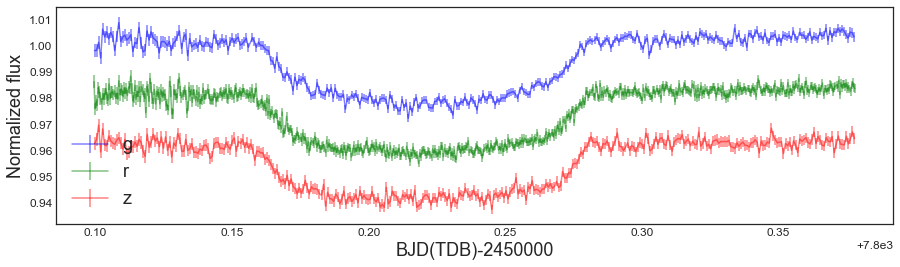

In [6]:
import matplotlib.pyplot as pl
%matplotlib inline

fluxcol =  'flux(r=11.0)'
errcol  =  'err(r=11.0)'

colors='b,g,r'.split(',')
fig,ax = pl.subplots(1,1,figsize=(15,4))

n=0
for b,c in zip(bands,colors):
    df = data[b]
    offset = n*0.02
    
    time = df.index
    flux = df[fluxcol]
    err  = df[errcol]
    
    #print(len(df))
    
    ax.errorbar(time, flux-offset, yerr=err, label=b, color=c, alpha=0.5)
    ax.set_ylabel('Normalized flux', fontsize=fontsize)
    n+=1
pl.legend(loc='lower left', fontsize=fontsize)
pl.xlabel('BJD(TDB)-2450000', fontsize=fontsize)

## setting-up the transit model 

See part2.

In [7]:
def scaled_a(p, t14, k, i=np.pi/2, impact_param=0):
    """
    Winn 2014 ("Transits and Occultations"), eq. 14
    """
    numer = np.sqrt( (k + 1)**2 - impact_param**2 )
    denom = np.sin(i) * np.sin(t14 * np.pi / p)
    return float(numer / denom)

def u_to_q(u1, u2):
    '''
    convert limb-darkening coefficients
    from u to q
    
    see Eq. 15 & 16 in Kipping 2013
    '''
    q1 = (u1 + u2)**2
    q2 = u1 / (2 * (u1 + u2))
    return q1, q2

def q_to_u(q1, q2):
    '''
    convert limb-darkening coefficients
    from q to u
    
    see Eq. 17 & 18 in Kipping 2013
    '''
    u1 = 2 * np.sqrt(q1) * q2
    u2 = np.sqrt(q1) * (1 - 2*q2)
    return u1, u2

from pytransit import MandelAgol

def transit_model_q(parameters, period, time, model=MandelAgol()):
    '''
    Compute flux using the Mandel-Agol model:
    
    \frac{I(\mu)}{I(1)} = 1 − u_1(1 − \mu) − u_2(1 − \mu)^2
    
    `parameters` must be a list containing:
    * k  : Rp/Rs: planet-star radius ratio
    * q1 : limb-darkening coefficient (for the linear term)
    * q2 : limb-darkening coefficient (for the quadratice term)
    * tc : transit center
    * a_s: a/Rs: scaled semi-major axis
    * b  : impact parameter
    '''
    k,q1,q2,tc,a,b = parameters
    
    #compute inclination
    inc   = np.arccos(b/a)
    #convert u to q
    u1,u2 = q_to_u(q1, q2)
    #evaluate the model
    m = model.evaluate(time, k, (u1,u2), tc, period, a, inc)
    
    return m

In [8]:
from astropy import units as u

_tc  = 2455696.93695
_P   = 4.301219
_inc = np.deg2rad(89.10)
_t14 = 0.13020
_b   = 0.172
_k   = np.sqrt(0.01804) # ± 0.00027

Rp = 1.24 #Rjup
Rs = 0.949*u.Rsun.to(u.Rjup) #Rsol to Rjup
k_ = Rp/Rs

_a_s = 11.52
a_s_  = scaled_a(_P, _t14, k_, i=_inc, impact_param=_b)

tc_0      = 7.8e3+0.22 #-2450000

In [9]:
import limbdark as ld

teff, uteff, logg, ulogg, feh, ufeh=5300,100, 4.460,0.06, 0.33,0.1

ldc_list     = []
ldc_err_list = []
ldp          = []

#for each band
for i in 'g*,r*,z*'.split(','):
    ldc = ld.claret(i, teff, uteff, logg, ulogg, feh, ufeh, n=int(1e4))
    ldp.append(ldc)
    
    #save in list
    #u1,u2
    ldc_list.append([ldc[0],ldc[2]]) #take first and third element of ldc 
    #uncertainties
    ldc_err_list.append([ldc[1],ldc[3]]) #take second and fourth element of ldc

## Transit model parameter estimation: Frequentist approach

### Maximum Likelihood Estimation (MLE)

See part3

In [10]:
import scipy.optimize as op

def obj(theta, p, t, f, err):
    '''
    objective function: chi-squared
    '''
    m = transit_model_q(theta, p, t)
    
    return np.sum(((f-m)/err)**2)

def rms(flux,flux_model):
    residual = flux-flux_model
    return np.sqrt(np.mean((residual)**2))

g-band
rms before: 0.0032
rms after: 0.0026

r-band
rms before: 0.0032
rms after: 0.0026

z-band
rms before: 0.0036
rms after: 0.0028



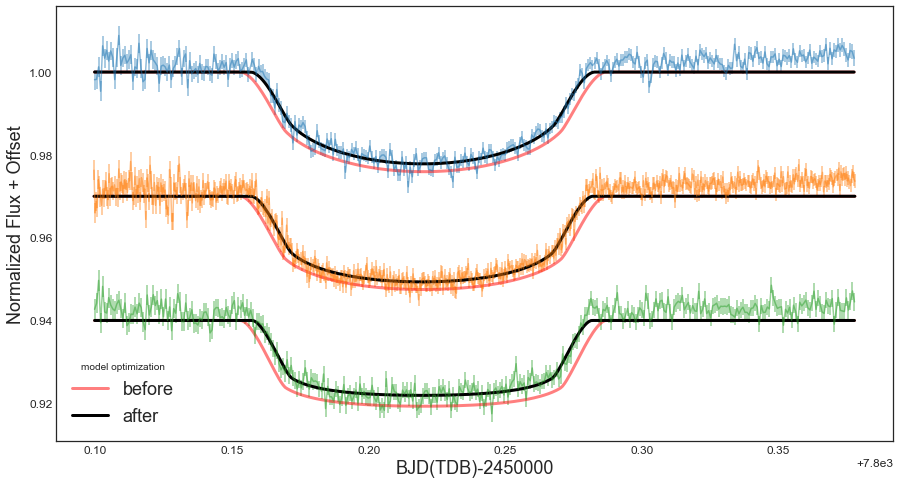

In [11]:
fig,ax = pl.subplots(1,1,figsize=(15,8))

optimized_transit_params = {} 

n=0
for b,u,c in zip(bands,ldc_list,colors):
    print('{}-band'.format(b))
    df=data[b]
    
    flux = df[fluxcol]
    time = df.index
    err  = df[errcol]
    
    #plot raw data with vertical offset
    offset = n*0.03
    pl.errorbar(time, flux-offset, yerr=err, alpha=0.5) 
    
    #compute q from u found in limbdark
    q1_,q2_ = u_to_q(u[0],u[1])

    #compute flux before optimization
    transit_params     = [k_,q1_,q2_,tc_0,_a_s,_b]
    transit_model_before  = transit_model_q(transit_params, _P, time)
    #rms before
    rms_before = rms(flux,transit_model_before)
    print('rms before: {:.4f}'.format(rms_before))
    
    #optimize parameters
    result = op.minimize(obj, transit_params,
                         args=(_P, time, flux, err), method='nelder-mead')
    
    #compute flux after optimization
    transit_params_after     = np.copy(result.x)
    transit_model_after  = transit_model_q(transit_params_after, _P, time)
    #rms after
    rms_after = rms(flux,transit_model_after)
    print('rms after: {:.4f}\n'.format(rms_after))
    
    #plot transit models
    #before (faint red)
    ax.plot(time, transit_model_before-offset, 'r-', lw=3, alpha=0.5)
    #after (black)
    ax.plot(time, transit_model_after-offset, 'k-', lw=3, alpha=1)
    ax.legend(fontsize=fontsize)
    
    #dict of optimized transit parameters to be used later
    optimized_transit_params[b] = transit_params_after
    n+=1
    
ax.set_ylabel('Normalized Flux + Offset', fontsize=fontsize)
ax.set_xlabel('BJD(TDB)-2450000', fontsize=fontsize)
ax.legend(['before','after'], title='model optimization',fontsize=fontsize)

In [12]:
optimized_transit_params

{'g': array([  1.28330953e-01,   6.94722181e-01,   4.65491536e-01,
          7.80021976e+03,   1.21625800e+01,   1.72028975e-01]),
 'r': array([  1.28408329e-01,   5.53907376e-01,   3.49739851e-01,
          7.80021952e+03,   1.22467056e+01,   1.72044914e-01]),
 'z': array([  1.25171086e-01,   3.43090243e-01,   2.07678538e-01,
          7.80021956e+03,   1.22930550e+01,   1.71164788e-01])}

## Systematics Modeling

See part4.

In [13]:
print('no. of data points:')
for b in bands:
    print('{}:\t{}'.format(b, len(data[b]['flux(r=11.0)'])))

no. of data points:
g:	375
r:	704
z:	376


In [14]:
def binning(x,y,bins):
    t=np.linspace(x[0],x[-1], bins)
    y=np.interp(x=t, xp=x, fp=y)
    return t, y

def flux_ratios(x1, y1, x2, y2, bins):
    numerator   = binning(x1,y1,bins)[1] #get y-component only
    denominator = binning(x2,y2,bins)[1]
    return numerator/ denominator

In [15]:
#systematics model
def systematics_model(w, aux_vec, time):
    '''
    systematics model consists of linear combination
    of constant coefficients (computed here) 
    and auxiliary vectors:
    
    color1, color2, dx, err, vert_offset
    
    The functional form of the model is
    s = [np.sum(c[k] * x**k) for k in np.arange(N)]
    '''
    #make sure there are 4 aux. vectors
    assert len(aux_vec) == 4
    
    #unpack aux_vec
    color1, color2, dx, err = aux_vec
    #add vertical offset
    vert_offset = np.ones_like(dx)
    #construct X with time
    X = np.c_[color1, color2, dx, err, vert_offset, time]
    
    #compute systematics model
    sys_model = np.dot(X,w)
        
    return sys_model

In [16]:
def find_2_bands(b):
    '''
    this function return the 2 bands
    other than the given band
    
    e.g. if g, return r & z
    '''
    if b=='g':
        return ['r','z']
    elif b=='r':
        return ['g','z']
    elif b=='z':
        return ['g','r']
    else:
        sys.exit(1)

g-band
rms (flux - transit_model): 0.0026
rms (flux/sys model - transit_model): 0.0014

rms difference: 0.0012

r-band
rms (flux - transit_model): 0.0026
rms (flux/sys model - transit_model): 0.0012

rms difference: 0.0014

z-band
rms (flux - transit_model): 0.0028
rms (flux/sys model - transit_model): 0.0013

rms difference: 0.0015



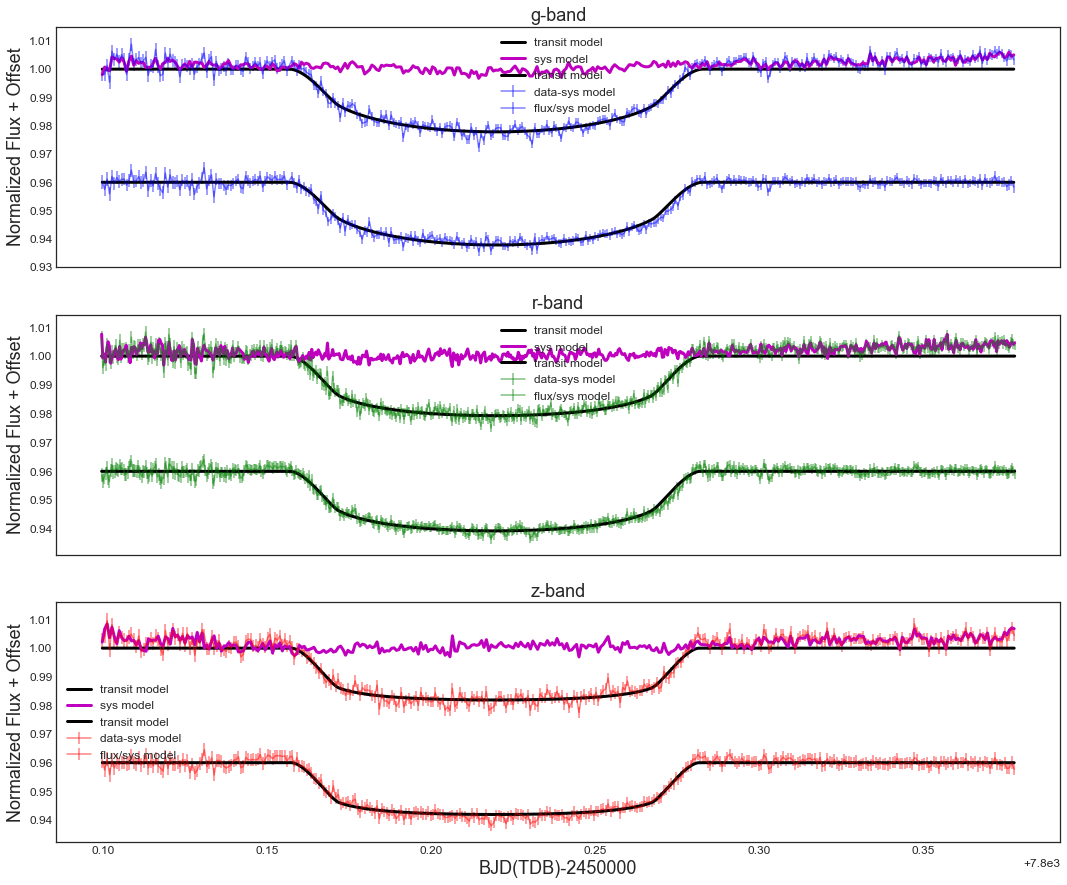

In [17]:
fig,ax = pl.subplots(3,1,figsize=(18,15), sharex=True)

X_list = {}
w_list = {}
aux_vec_list = {}

n=0
for b,u,c in zip(bands,ldc_list,colors):
    print('{}-band'.format(b))
    df=data[b]
    
    flux = df[fluxcol]
    time = df.index
    err  = df[errcol]
    
    dx   = df['dx(pix)']
    dy   = df['dy(pix)']
    airmass = df['airmass']
    #fwhm    = df['fwhm(pix)']
    #sky     = df['sky(ADU)']
    #peak    = df['peak(ADU)']
    
    #plot flux raw data
    ax[n].errorbar(time, flux, yerr=err, 
                   label='data-sys model', alpha=0.5, color=c) 
    
    transit_params = optimized_transit_params[b]
    transit_model  = transit_model_q(transit_params, _P, time)
    
    #plot best fit transit model
    ax[n].plot(time, transit_model, 'k-', lw=3, label='transit model')
    data[b]['transit_model'] = transit_model 
    
    #plot residual with offset
    sys = flux / transit_model
    data[b]['flux/transit_model'] = sys
    
    ##ax[n].plot(time, resid+0.94, 'm-', lw=3, label='residual')
    ##ax[n].plot(time, sys+0.94, 'm-', lw=3, label='residual')
       
    #determine correct band
    b1,b2 = find_2_bands(b)
    
    #compute color
    color1 = flux_ratios(time,flux,data[b1].index,
                       data[b1][fluxcol], 
                       bins=len(df))
    color2 = flux_ratios(time,flux,data[b2].index,
                       data[b2][fluxcol], 
                       bins=len(df))
    #add color to original dataframe
    data[b]['color1'] = color1
    data[b]['color2'] = color2
    
    #add vertical offset
    vert_offset = np.ones_like(dx)
    
    #construct X with time
    X = np.c_[color1, color2, dx, err, vert_offset, time]
    X_list[b] = X
    
    #compute systematics model
    w = np.linalg.solve(np.dot(X.T,X), np.dot(X.T, sys))
    w_list[b] = w
    
    #supply 4 vec, 2 others addded inside systematics_model function
    aux_vec = [color1, color2, dx, err]
    aux_vec_list[b] = aux_vec
    
    #evaluate model
    sys_model = systematics_model(w, aux_vec, time)
    
    data[b]['sys_model'] = sys_model
    
    resid = flux/sys_model - transit_model
    data[b]['residual'] = resid
    
    #compute rms
    rms_before = rms(flux, transit_model)
    #rms_after = rms(resid,sys_model)
    rms_after = rms(flux/sys_model,transit_model)
    
    print('rms (flux - transit_model): {:.4f}'.format(rms_before))
    print('rms (flux/sys model - transit_model): {:.4f}\n'.format(rms_after))
    print('rms difference: {:.4f}\n'.format(rms_before-rms_after))
    
    
    
    #plot systematics model
    ax[n].plot(time, sys_model, 'm-', lw=3, label='sys model')
    
    #plot corrected flux
    ax[n].errorbar(time, flux/sys_model-0.04, yerr=err, 
                   label='flux/sys model', alpha=0.5, color=c) 
    ax[n].plot(time, transit_model-0.04, 'k-', lw=3, label='transit model')
    
    ax[n].set_title('{}-band'.format(b), fontsize=fontsize)
    ax[n].legend(fontsize=12)
    ax[n].set_ylabel('Normalized Flux + Offset', fontsize=fontsize)
    n+=1
    
pl.xlabel('BJD(TDB)-2450000', fontsize=fontsize)

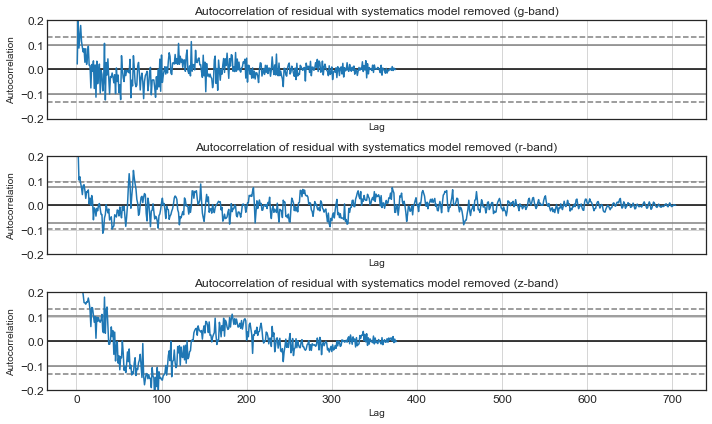

In [18]:
fig, ax = pl.subplots(nrows=3,ncols=1,figsize=(10,6), sharex=True)

n=0
for b in bands:
    df   = data[b]
    time = df.index
    
    #get residual computed earlier    
    resid_wo_sys = data[b]['residual']
        
    pd.plotting.autocorrelation_plot(resid_wo_sys, ax=ax[n])
    ax[n].set_title('Autocorrelation of residual with systematics model removed ({}-band)'.format(b))
    ax[n].set_ylim(-0.2,0.2)
    n+=1
fig.tight_layout()

## Reduced $\chi^2$

In [19]:
def chisq(resid, err, ndata=None, nparams=None, reduced=False):
    '''
    resid: residual = flux/sys_model - transit_model
    err  : error in flux
    '''
    if reduced:
        assert ndata is not None and nparams is not None
        dof = ndata - nparams
        return sum((resid / err)**2) / (dof)
    else:
        return sum((resid / err)**2)

In [20]:
reduced_chi2 = {}

errcol = 'err(r=11.0)'
newerrcols = []

for b in bands:
    df = data[b]
    
    ndata = len(df)
    nparams = len(aux_vec)
    
    time  = df.index
    flux  = df[fluxcol]
    err   = df[errcol]
    
    transit_model = data[b]['transit_model']
    sys_model = data[b]['sys_model']
    
    resid = flux/sys_model - transit_model
    
    #resid = df['resid']
    chi2 = chisq(resid, err, reduced=False)
    red_chi2 = chisq(resid, err, ndata, nparams, reduced=True)
    
    #save
    reduced_chi2[b] = red_chi2
    col='err(r=11.0)*{:.2f}'.format(red_chi2)
    print(col)
    newerrcols.append(col)
    df[col] = err*red_chi2
    #print(len(err*factor))
    
    print('chi2 ={:.4f}'.format(chi2))
    print('reduced chi2 ={:.4f}'.format(red_chi2))

err(r=11.0)*0.75
chi2 =278.9772
reduced chi2 =0.7520
err(r=11.0)*0.56
chi2 =390.7006
reduced chi2 =0.5581
err(r=11.0)*0.43
chi2 =160.7209
reduced chi2 =0.4320


## beta factor

In [21]:
def binned(a, binsize, fun=np.mean):
    a_b = []
    for i in range(0, a.shape[0], binsize):
        a_b.append(fun(a[i:i+binsize], axis=0))
        
    return a_b

def beta(residuals, timestep, start_min=5, stop_min=20, return_dict=False):
    """
    residuals : flux/sys_model - transit_model
    timestep  : time interval between datapoints in seconds
    
    Final beta is computed by taking the median of the betas:
                np.nanmedian(betas)
    """

    assert timestep < start_min * 60
    ndata = len(residuals)
    
    sigma1 = np.std(residuals)

    min_bs = int(start_min * 60 / timestep)
    max_bs = int(stop_min  * 60 / timestep)

    betas      = []
    betas_dict = {}
    for bs in np.arange(min_bs, max_bs + 1):
        nbins = ndata / bs
        sigmaN_theory = sigma1 / np.sqrt(bs) * np.sqrt( nbins / (nbins - 1) )
        
        #binning
        sigmaN_actual = np.std(binned(residuals,bs))
        beta = sigmaN_actual / sigmaN_theory
        
        betas_dict[bs] = beta
        betas.append(beta)
        
    if return_dict:
        return betas_dict
    else:
        return np.nanmedian(betas)

In [22]:
beta_factor = {}

exptimes = [60,30,60] #sec

for b,col,ts in zip(bands,newerrcols,exptimes):
    df = data[b]
        
    resid = data[b]['residual'].values
    
    beta_fac = beta(resid, ts, start_min=5, stop_min=20)
    beta_factor[b]= beta_fac
    
    err = df[col]
    
    #inflate error once more (after rescaling red. chi-squared)
    inflated_err = err * beta_fac
    
    #add to df 
    #data[b]['err_inflated'] = inflated_err
    
    print('beta factor ={:.4f}'.format(beta_fac))
    #print(len(inflated_err))

beta factor =1.4815
beta factor =1.7070
beta factor =1.8796


---

## Transit model parameter estimation: Bayesian approach

* Simultaneous modeling (part5)
 * transit model
 * systematics model
* Bayes' theorem (part5)
 * Likelihood
 * Prior
 
* MCMC using `emcee`

### Bayes' Theorem

The posterior probability density given a parameter vector $\theta$ and observational data $D$ is described by the Bayes' theorem as (c.f. [wiki](https://en.wikipedia.org/wiki/Bayes%27_theorem)):

$$
P(\theta|D) \propto P(\theta) \times P(D|\theta) \\
\rm{Posterior \propto Prior \times Likelihood}
$$
where $P(\theta)$ is the prior, $P(D|\theta)$ is the likelihood for the data.

### Likelihood for transit & systematics parameters

Assuming that the variables in our model are independent, identically distributed ([iid](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables)) random variables, we can expect that the residual (data - transit - systematics model) follows a Gaussian distribution. 

$$
\mathcal{L}(\theta|M) = N(\mu,\sigma) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp-\frac{(x-\mu)^2}{2\sigma^2}
$$

### $\log$ Likelihood (ll)

The likelihood is a product of individual observation probabilities, and has the unfortunate tendency to end up being either very small or very big. This causes computational headaches, and it is better to work with log probabilities instead, so that

$$
\log \mathcal{L}(\theta|D) = -\frac{1}{2}\Big[\log(2\pi) +2\log\sigma +\Big(\frac{x-\mu}{\sigma}\Big)^2\Big]
$$

Now, let's write a function that computes the value above.

In [23]:
def loglike(params_full, p, t, f, err, aux_vec, log2pi=np.log(2*np.pi),
            ret_mod=False, ret_sys=False, ret_full = False):
    '''
    * computes the log likelihood given the optimized transit and model parameters
    * either or both transit and systematics models can also be returned
    '''
    
    m = transit_model_q(params_full[:6], p, t)
    
    #color1,color2,dx,err = aux_vec
    s = systematics_model(params_full[6:], aux_vec, t) # #add sys model
    
    if ret_mod:
        return m
    if ret_sys:
        return s
    if ret_full:
        return m*s
    
    resid = f / s - m
    div   = resid/err
    N     = div.size
    
    return -sum(np.log(err)) -0.5*N*log2pi -0.5*np.dot(div,div)

### negative log likelihood (nll)

Goal:
* Maximize likelihood but `scipy.optimize.minimize` is (only?) available
* Use nll instead! --> minimizing nll == maximizing ll !!!

In [24]:
#negative log-likelihood
nll = lambda *x: -loglike(*x)

## Simultaneous modeling of transit and systematics parameters (per band)
### MLE optimization

Here we will use `nll` because `scipy.optimize.minimize` implements minimization to get the optimum set of parameters. 

--g--
NLL before: -1927.8676609336699
NLL after: -1944.204064750469
--r--
NLL before: -3692.954198392999
NLL after: -3700.8304702444666
--z--
NLL before: -1909.4747588672465
NLL after: -1918.7871427608843


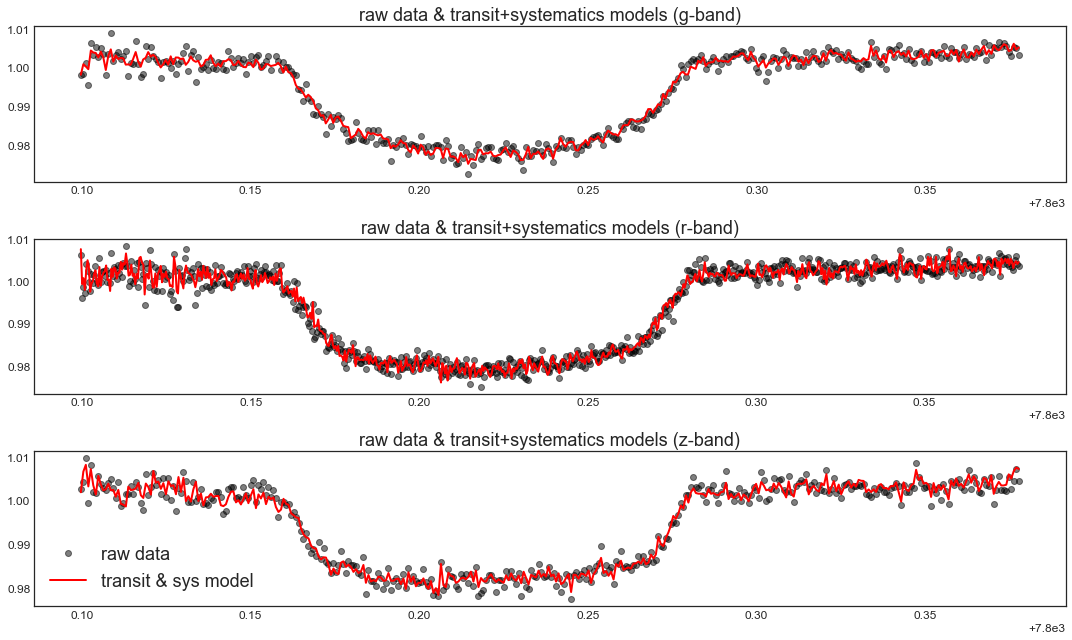

In [25]:
#parameters vector: 6 transit, 4+2 systematics

import scipy.optimize as op
fig = pl.figure(figsize=(15,9))

save_model = True

n=0
for b in bands:
    df=data[b]

    flux = df[fluxcol]
    time = df.index

    #sys mod params
    airmass   = df['airmass']
    err       = df['err(r=11.0)']
    dx        = df['dx(pix)']
    #dy        = df['dy(pix)']
    print('--{}--'.format(b))
    
    #transit params computed before
    transit_params = optimized_transit_params[b]
    
    #weights computed before
    w = w_list[b]
    
    #aux_vec saved before
    aux_vec = aux_vec_list[b]
    
    #combine optimized transit params and sys params
    full_params = np.concatenate((transit_params, w), axis=0)
    
    #compute nll
    print ("NLL before: {}".format(nll(full_params, 
                                       _P, 
                                       time, 
                                       flux, 
                                       err, 
                                       aux_vec)))
    #MLE optimization of transit+sys parameters
    result = op.minimize(nll, full_params,    
                         args=(_P, time, flux, err, aux_vec),
                         method='nelder-mead')
    
    #result of optimization
    print ("NLL after: {}".format(nll(result.x,   
                                      _P, 
                                      time, 
                                      flux, 
                                      err, 
                                      aux_vec)))
    
    #compute models
    full_model    = loglike(result.x, _P, time, flux, err, aux_vec, 
                            ret_full=True)
    transit_model = loglike(result.x, _P, time, flux, err, aux_vec, 
                     ret_mod=True)
    sys_model     = loglike(result.x, _P, time, flux, err, aux_vec, 
                     ret_sys=True)
    
    resid = flux/sys_model - transit_model
    
    if save_model:
        data[b]['transit_model'] = transit_model
        data[b]['sys_model']     = sys_model
        data[b]['full_model']    = full_model
        data[b]['residual']      = resid
    
    rms_err = np.sqrt(np.mean(resid**2))
    
    ax = pl.subplot(3,1,n+1)
    #plot corrected data
    ax.plot(time, flux, 'ko', alpha=0.5, label='raw data')
    ax.set_title('raw data & transit+systematics models ({}-band)'.format(b), fontsize=fontsize)
    #plot transit+sys models
    ax.plot(time, full_model, 'r-', lw=2, label='transit & sys model');
    n+=1
    
pl.legend(fontsize=fontsize)
fig.tight_layout()

Indeed after optimization, we achieved smaller negative nlp values or higher logprob values.

### Priors for transit parameters

Giving a prior on a parameter puts limits/bounds on the range of values it can have.

The simplest prior is a uniform prior $U(x_1,x_2)$ where it is 1 within the interval $x_1,x_2$ and 0 elsewhere. 
* UP  - Impact parameter
* UP  - White noise std
* UP  - limb darkening q1
* UP - limb darkening q2

Another useful prior is a normal prior $N(\sigma,\mu)$ centered at $\mu$ and has a thickness $\sigma$.
* NP  - Transit centre
* NP  - Period
* NP  - Stellar density
* NP  - Baseline constant
* JP  - planet-star area ratio

Perhaps we can set the minimum width of the uniform prior for a given parameter by taking into account their measurement uncertainties. 

In [26]:
import numpy as np
from uncertainties import ufloat 
from astropy import units as u

P   = ufloat(4.301219,0.000019)
Rp  = ufloat(1.523,0.442)   #+0.442-0.226

Rs_jup  = 0.949*u.Rsun.to(u.Rjup)
Rs_jup_u= 0.08*u.Rsun.to(u.Rjup) #+0.08/-0.037
Rs  = ufloat(Rs_jup,Rs_jup_u)

t14 = ufloat(0.1302,0.0008) 
b   = ufloat(0.172,0.079)   #+0.079/-0.074     
a_s = ufloat(11.52,0.74)
k   = ufloat(np.sqrt(0.01804),np.sqrt(0.00027)) 
inc = ufloat(np.deg2rad(89.10),np.deg2rad(0.4))

In [27]:
def tshape_approx(a, k, b):
    """
    Seager & Mallen-Ornelas 2003, eq. 15
    """
    i = np.arccos(b/a)
    alpha = (1 - k)**2 - b**2
    beta = (1 + k)**2 - b**2
    return np.sqrt( alpha / beta )


def max_k(tshape):
    """
    Seager & Mallen-Ornelas 2003, eq. 21
    """
    return (1 - tshape) / (1 + tshape)

In [28]:
from astropy import units
from astropy import constants

def rhostar(p, a):
    """
    Eq.4 of Kipping 2014. 
    Assumes circular orbit & Mp<<Ms
    
    http://arxiv.org/pdf/1311.1170v3.pdf
    
    c.f. Seager & __ 2002
    """
    p = p * units.d
    gpcc = units.g / units.cm ** 3
    rho_mks = 3 * np.pi / constants.G / p ** 2 * a ** 3
    return rho_mks.to(gpcc).value

In [29]:
rhostar(_P,_a_s)

1.5632432442092328

We can now put the reasonable values above into our logprior function.

In [30]:
from scipy import stats
def logprior(full_params,u_prior=None):
    '''
    full_paras: transit+systematic model parameters
    up: limb-darkening prior for u1,u2
    '''
    #unpack transit parameters
    k,q1,q2,tc,a_s,impact_param = full_params[:6]
    inc=np.arccos(impact_param/a_s)
    
    tshape = tshape_approx(a_s, k_, _b)
    kmax = max_k(tshape)
    
    rho_s = rhostar(_P, a_s)

    #Uniform priors: return log 0= inf if outside interval
    if  q1  < 0 or q1 > 1 or \
        q2  < 0 or q2 > 1 or \
        k   < 0 or k  > kmax or \
        impact_param   < 0 or impact_param  > 1 or \
        inc > np.pi/2     or \
        a_s < 0 or a_s  > 13 or \
        rho_s < 1 or rho_s > 10 or \
        tc < tc_0-_t14/2 or tc > tc_0+_t14:
        
        #print('off limits encountered in logprior')
        return -np.inf
    
    #if they are inside interval, add log 1 = 0 to logprior
    
    #logprior
    lp = 0
    
    #Normal priors on q1,q2 with sigma=uncertainty from Claret+2012
    u1,u2 = q_to_u(q1,q2)
    
    if u_prior is not None:
        #evaluate log of N(u,sigma)
        sigma1=u_prior[1]
        sigma2=u_prior[3]
        #add to logprior
        lp += np.log(stats.norm.pdf(u1, loc=u_prior[0], scale=sigma1))
        lp += np.log(stats.norm.pdf(u2, loc=u_prior[2], scale=sigma2))
    
    #what are our priors for systematics model parameters?
    
    return lp

Evaluate logprior

In [31]:
logprior(full_params)

0

This means that the transit parameters are within the bounds set by the prior.

### logprob=logprior+loglike (per band)

Let's combine logprior and loglike into one function called logprob.

In [32]:
param_names='k,q1,q2,tc,a_s,b,w0,w1,w2,w3,w4,w5'.split(',')

In [33]:
def logprob(full_params,
            time,
            flux,
            period,
            color1,
            color2,
            dx,
            err,
            ldc_prior=None,
            qerr=False):
        
    #unpack full params for 3 bands
    
    if qerr:
        k,tc,a_s,impact_param,lsjit,q1,q2,w0,w1,w2,w3,w4,w5 = full_params
    else:
        k,tc,a_s,impact_param,q1,q2,w0,w1,w2,w3,w4,w5 = full_params
    
    #set up auxiliary vector for each band
    aux_vec = color1, color2, dx, err
    
    #sum loglike for each band
    ll  = loglike(full_params, period, time, flux, err, aux_vec)
    
    if ldc_prior is not None:
        lp  = logprior(full_params, u_prior=ldc_prior)
    else:
        #no ldc prior (if stellar parameters not known)
        lp  = logprior(full_params)
    
    if np.isnan(ll).any():
        #print('NaN encountered in loglike')
        return -np.inf
    
    #total: sum of prior and likelihood
    return lp + ll

#negative log prob
nlp = lambda *x: -logprob(*x)

In [34]:
b = 'g'
n = 2

df = data[b]
time = df.index
flux = df[fluxcol]
err  = df[errcol]
color1 = df['color1']
color2 = df['color2']
dx     = df['dx(pix)']
ldc    = ldp[n]

theta = optimized_transit_params[b]
w     = w_list[b]

full_params = np.concatenate((theta,w),axis=0)

Evaluate `logprob` without `ldc_prior`:

In [35]:
logprob(full_params,
        time,
        flux,
        _P,
        color1,
        color2,
        dx,
        err)

1927.8676609336699

This is the total log probability for the transit and systematics models for z-band without prior on limb-darkening coefficients.

Now, evaluate `logprob` with `ldc_prior=ldp`:

In [36]:
logprob(full_params,
        time,
        flux,
        _P,
        color1,
        color2,
        dx,
        err,
        ldc_prior=ldc)

1846.8462964704615

## Optimization of log like + log prior

Now, we will use `nlp` (instead of logprob) because `scipy.optimize.minimize` implements minimization to find the optimize sets of parameters.

--g-band---
NLL before: -1932.4329592007432
NLL after: -1953.366329270394
--r-band---
NLL before: -3697.8527779408196
NLL after: -3714.7650437506645
--z-band---
NLL before: -1913.7353302830832
NLL after: -1922.9152579591764


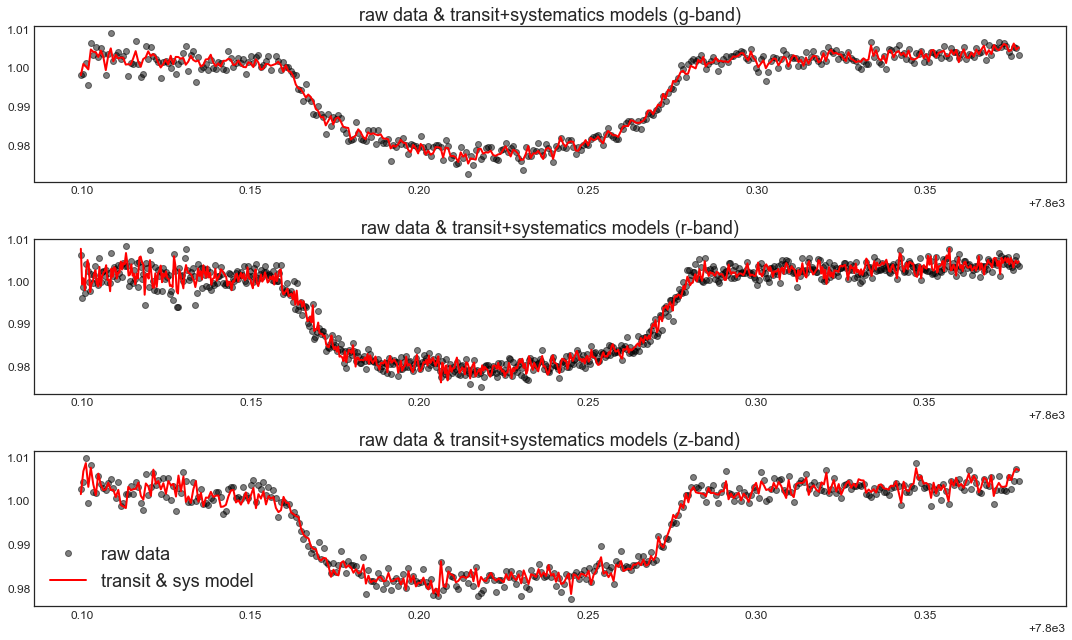

In [37]:
import scipy.optimize as op
fig = pl.figure(figsize=(15,9))

save_model = True

n=0
for b in bands:
    print('--{}-band---'.format(b))
    df = data[b]
    time = df.index
    flux = df[fluxcol]
    err  = df[errcol]
    color1 = df['color1']
    color2 = df['color2']
    dx     = df['dx(pix)']
    ldc    = ldp[n]
    
    theta = optimized_transit_params[b]
    w     = w_list[b]
    
    full_params = np.concatenate((theta,w),axis=0)
    
    #compute nll
    print("NLL before: {}".format(nlp(full_params,
                                        time,
                                        flux,
                                        _P,
                                        color1,
                                        color2,
                                        dx,
                                        err,
                                         ldc)))
    #MLE optimization of transit+sys parameters
    result = op.minimize(nlp, full_params,    
                         args=(time, flux, _P, color1, color2, dx, err, ldc),
                         method='nelder-mead')
    
    #result of optimization
    print("NLL after: {}".format(nlp(result.x,
                                        time,
                                        flux,
                                        _P,
                                        color1,
                                        color2,
                                        dx,
                                        err,
                                         ldc)))
    
    aux_vec = [color1,color2,dx,err]
    #compute models
    full_model    = loglike(result.x, _P, time, flux, err, aux_vec, 
                            ret_full=True)
    transit_model = loglike(result.x, _P, time, flux, err, aux_vec, 
                     ret_mod=True)
    sys_model     = loglike(result.x, _P, time, flux, err, aux_vec, 
                     ret_sys=True)
    
    resid = flux/sys_model - transit_model
    
    if save_model:
        data[b]['transit_model'] = transit_model
        data[b]['sys_model']     = sys_model
        data[b]['full_model']    = full_model
        data[b]['residual']      = resid
    
    rms_err = np.sqrt(np.mean(resid**2))
    
    ax = pl.subplot(3,1,n+1)
    #plot corrected data
    ax.plot(time, flux, 'ko', alpha=0.5, label='raw data')
    ax.set_title('raw data & transit+systematics models ({}-band)'.format(b), fontsize=fontsize)
    #plot transit+sys models
    ax.plot(time, full_model, 'r-', lw=2, label='transit & sys model');
    n+=1
    
pl.legend(fontsize=fontsize)
fig.tight_layout()

Indeed after optimization, we achieved smaller negative nlp values or higher logprob values.

### Re-organizing vectors (not necessary but helpful)

In [38]:
#ignore tc, a_s, b
k_g,q1g,q2g,_,_,_ = optimized_transit_params['g']
k_r,q1r,q2r,_,_,_ = optimized_transit_params['r']
k_z,q1z,q2z,_,_,_ = optimized_transit_params['z']

In [39]:
times    = []
fluxes   = []
colors1  = []
colors2  = []
errs     = []
dxs      = []
#dys      =[]
#airmasses= []

for b in bands:
    #sys mod params
    df = data[b]
    times.append(df.index)
    fluxes.append(df['flux(r=11.0)'])
    colors1.append(df['color1'])
    colors2.append(df['color2'])
    errs.append(df['err(r=11.0)'])    
    dxs.append(df['dx(pix)'])    

In [40]:
color1_coeffs= []
color2_coeffs= []
dx_coeffs    = []
err_coeffs   = []
vert_offsets = []
time_coeffs  = []

for b in bands:
    color1_coeffs.append(w_list[b][0])
    color2_coeffs.append(w_list[b][1])
    dx_coeffs.append(w_list[b][2])
    err_coeffs.append(w_list[b][3])
    vert_offsets.append(w_list[b][4])
    time_coeffs.append(w_list[b][5])

In [41]:
#unpack
w0g,w0r,w0z = color1_coeffs
w1g,w1r,w1z = color2_coeffs
w2g,w2r,w2z = dx_coeffs
w3g,w3r,w3z = err_coeffs
w4g,w4r,w4z = vert_offsets
w5g,w5r,w5z = time_coeffs

Test for sanity.

In [42]:
for n,b in enumerate(bands):
    print('{}-band'.format(b))
    transit_params = optimized_transit_params[b]
    sys_params     = [color1_coeffs[n], 
                      color2_coeffs[n], 
                      dx_coeffs[n], 
                      err_coeffs[n],
                      vert_offsets[n],
                      time_coeffs[n]]
    
    full_params = np.concatenate((transit_params,sys_params),axis=0)
    lp = logprob(full_params,
            times[n],
            fluxes[n],
            _P,
            colors1[n],
            colors2[n],
            dxs[n],
            errs[n],
            ldc_prior=None)
    print(lp)

g-band
1927.86766093
r-band
3692.95419839
z-band
1909.47475887


In [43]:
for n,b in enumerate(bands):
    print('{}-band'.format(b))
    transit_params = optimized_transit_params[b]
    sys_params     = [color1_coeffs[n], 
                      color2_coeffs[n], 
                      dx_coeffs[n], 
                      err_coeffs[n],
                      vert_offsets[n],
                      time_coeffs[n]]
    
    full_params = np.concatenate((transit_params,sys_params),axis=0)
    lp = logprob(full_params,
            times[n],
            fluxes[n],
            _P,
            colors1[n],
            colors2[n],
            dxs[n],
            errs[n],
            ldc_prior=ldp[n])
    print(lp)

g-band
1932.4329592
r-band
3697.85277794
z-band
1913.73533028


## MCMC with `emcee`

* [emcee](https://github.com/dfm/emcee)
* See also [MC3](https://github.com/pcubillos/MCcubed)

![img](images/mcmc.png)

In [44]:
import emcee
emcee.__version__

'2.2.1'

Basically, `emcee` requires:
* a cost function (i.e. logprobability)
* ndim: number of dimensions or free parameters
* nwalkers: number of walkers (exploring the parameter space in parallel) 
* nsteps: number of steps that the walkers have to take

The rule of thumb is to have ~10x more number of walkers than ndim.

## Set-up emcee

First, we set-up the `emcee.EnsembleSampler` clas by defining
* nwalkers, 
* ndim, 
* logprob, 
* args: argument or fixed parameters that are needed to evaluate logprob (e.g. period, flux, etc.) 

Also, 
* threads=1
is optional but sometimes useful to speed-up computation.

Usually, mcmc in done in a two-step process. 
1. Short run (nsteps~1e3) for sanity check and checking burn-in stage; 
2. Longer run (nsteps~1e6) until convergence

### g-band (n=0)

In [45]:
import emcee

ndim = len(full_params)

if ndim > 12:
    nwalkers = 8 * ndim  
else: 
    nwalkers = 16 * ndim

nsteps1 = 100

#input to the model
n=0
args = [times[n], fluxes[n], _P, colors1[n], colors2[n], dxs[n], errs[n], ldp[n]]

sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob, args=args, threads=1)

Before running the simulation, each walker of the sampler must have defined starting position (determined from previous optimization). This is usually done by adding small random displacements from the original position of the optimized value for each parameter's walker.

In [46]:
#to generate reproducible random numbers
np.random.seed(42)

pos0 = []
#random numbers "around" the initial values
for i in range(nwalkers):
    #pick a random number
    rnum = 1e-8 * np.random.randn(ndim)
    #add to each initial value of parameter
    new_param_vector = np.array(full_params) +rnum
    #append
    pos0.append(new_param_vector)

Finally, we will initiate the simulation by invoking the `emcee.EnsembleSampler.sample` method. We optionally add `tqdm` to show the progress of the simulation.

In [47]:
from tqdm import tqdm

#begin
for pos,lnp,rstate in tqdm(sampler.sample(pos0, iterations=nsteps1)):
    pass

100it [01:10,  1.42it/s]


In [49]:
chain = sampler.chain 
chain.shape

(192, 100, 12)

These are the nwalkers, nsteps, and ndim. We can visualize the evolution of each walker during its first nsteps.

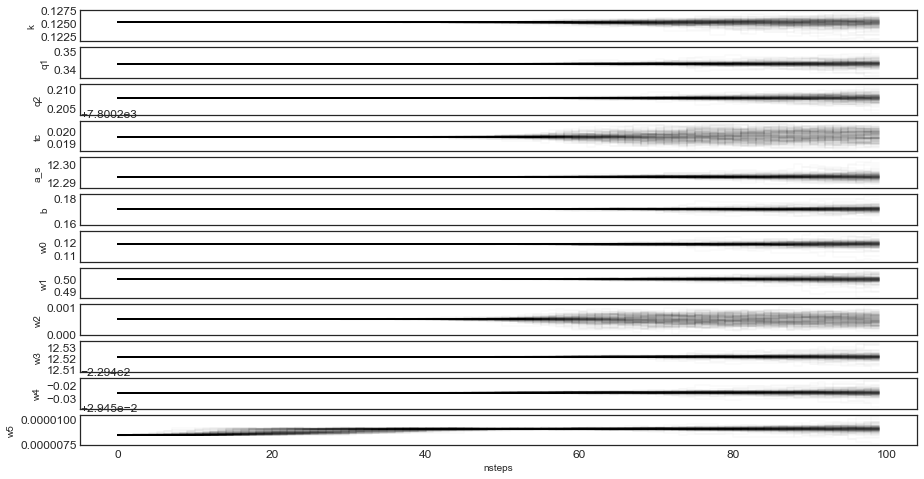

In [61]:
fig, axs = pl.subplots(ndim, 1, figsize=(15,ndim/1.5), sharex=True)

nwalkers, nsteps, ndim = chain.shape
[axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=4./nwalkers) for i,c in enumerate(chain.T)]
[axs.flat[i].set_ylabel(l) for i,l in enumerate(param_names)]
    
pl.xlabel('nsteps')

## Save results

Reset the chain and continue from the last position.

In [ ]:
nsteps2 = 100

sampler.reset()

#begin
for pos,lnp,rstate in tqdm(sampler.sample(pos, iterations=nsteps2)):
    pass

In [ ]:
fig, axs = pl.subplots(ndim, 1, figsize=(15,ndim/1.5), sharex=True)

chain=sampler.chain
nwalkers, nsteps, ndim = chain.shape
[axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=4./nwalkers) for i,c in enumerate(chain.T)]
[axs.flat[i].set_ylabel(l) for i,l in enumerate(param_names)]
    
pl.xlabel('nsteps')

Then do the same for r- and z-bands.

# Appendix

## Convergence
* [Gelman-Rubin statistic]()

In [ ]:
def gelman_rubin(chains, verbose=False):
    assert chains.ndim == 3
    nn = chains.shape[1]
    mean_j = chains.mean(axis=1)
    var_j = chains.var(axis=1)
    B = nn * mean_j.var(axis=0)
    W = var_j.mean(axis=0)
    R2 = ( W*(nn-1)/nn + B/nn ) / W
    return np.sqrt(R2)

In [ ]:
gelman_rubin(chain)

## Rescaling uncertainties (simultaneous)

In [45]:
def binned(a, binsize, fun=np.mean):
    a_b = []
    for i in range(0, a.shape[0], binsize):
        a_b.append(fun(a[i:i+binsize], axis=0))
        
    return np.array(a_b)

def binned_rms(residuals, timestep, start_min=5, stop_min=20):
    """
    residuals : flux/sys_model - transit_model
    timestep  : time interval between datapoints in seconds
    """

    assert timestep < start_min * 60
    ndata = len(residuals)

    min_bs = int(start_min * 60 / timestep)
    max_bs = int(stop_min  * 60 / timestep)

    rms_err      = []
    rms_err_dict = {}
    for bs in np.arange(min_bs, max_bs + 1):
        nbins = ndata / bs
                
        #binning       
        rms_val = np.sqrt(np.mean(binned(residuals,bs)**2))
        rms_err.append(rms_val)
        rms_err_dict[bs] = rms_val
        
    return rms_err_dict

In [46]:
rms_binned = {}

exptimes = [60,30,60] #sec

for b,ts in zip(bands,exptimes):
    df=data[b]
    resid = df['residual'].values
    rms_bin = binned_rms(resid, ts, start_min=5, stop_min=40)
    rms_binned[b] = rms_bin

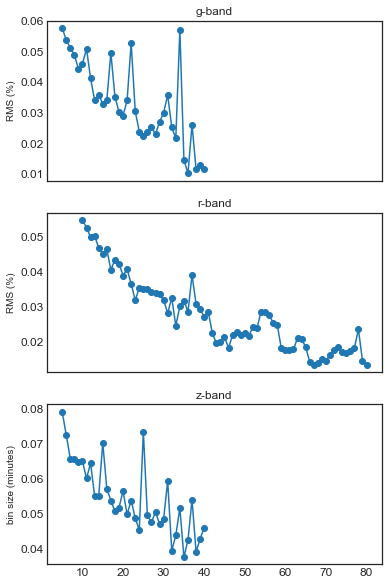

In [47]:
fig,ax=pl.subplots(3,1,figsize=(6,10), sharex=True)
b='g'
n=0
for b in bands:
    ax[n].plot(list(rms_binned[b].keys()),
               np.array(list(rms_binned[b].values()))*100, 'o-')
    ax[n].set_title('{}-band'.format(b))
    ax[n].set_ylabel('RMS (%)')
    #ax[n].set_ylim(-0.001,0.001)
    n+=1
ax[n-1].set_ylabel('bin size (minutes)')

## Reduced $\chi^2$

In [48]:
def chisq(resid, sig, ndata=None, nparams=None, reduced=False):
    if reduced:
        assert ndata is not None and nparams is not None
        dof = ndata - nparams
        return np.sqrt(sum((resid / sig)**2)/ (dof))
    else:
        return sum((resid / sig)**2)

In [49]:
reduced_chi2 = {}

newerrcols = []

for b in bands:
    print('{}-band'.format(b))
    df = data[b]
    
    ndata = len(df)
    nparams = len(full_params)
    
    resid = df['residual']
    err   = df['err(r=11.0)']
    
    chi2 = chisq(resid, err, ndata, nparams)
    red_chi2 = chisq(resid, err, ndata, nparams, reduced=True)
    
    #save
    reduced_chi2[b] = red_chi2
    col='err(r=11.0)*{:.2f}'.format(red_chi2)
    newerrcols.append(col)
    data[b][col] = err*red_chi2
    
    print('chi2 ={:.2f}'.format(chi2))
    print('reduced chi2 ={:.4f}'.format(red_chi2))

g-band
chi2 =234.04
reduced chi2 =0.8030
r-band
chi2 =357.78
reduced chi2 =0.7190
z-band
chi2 =141.97
reduced chi2 =0.6245


## red noise: beta factor

In [50]:
def beta(residuals, timestep, start_min=5, stop_min=20, return_dict=False):
    """
    residuals : flux/sys_model - transit_model
    timestep  : time interval between datapoints in seconds
    
    Final beta is computed by taking the median of the betas:
                np.nanmedian(betas)
    """

    assert timestep < start_min * 60
    ndata = len(residuals)
    
    sigma1 = np.std(residuals)

    min_bs = int(start_min * 60 / timestep)
    max_bs = int(stop_min  * 60 / timestep)

    betas      = []
    betas_dict = {}
    for bs in np.arange(min_bs, max_bs + 1):
        nbins = ndata / bs
        sigmaN_theory = sigma1 / np.sqrt(bs) * np.sqrt( nbins / (nbins - 1) )
        
        #binning
        sigmaN_actual = np.std(binned(residuals,bs))
        beta = sigmaN_actual / sigmaN_theory
        
        betas_dict[bs] = beta
        betas.append(beta)
        
    if return_dict:
        return betas_dict
    else:
        return np.nanmedian(betas)

In [51]:
beta_factor_list = {}

exptimes = [60,30,60] #sec

for b,col,ts in zip(bands,newerrcols,exptimes):
    df = data[b]
    resid = df['residual'].values
    
    beta_fac = beta(resid, ts, start_min=5, stop_min=20, return_dict=True)
    beta_factor_list[b]= beta_fac

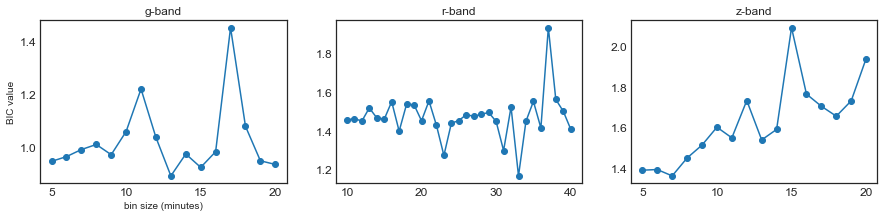

In [52]:
fig,ax=pl.subplots(1,3,figsize=(15,3))
b='g'
n=0
for b in bands:
    ax[n].plot(list(beta_factor_list[b].keys()),list(beta_factor_list[b].values()),'o-')
    ax[n].set_title('{}-band'.format(b))
    ax[0].set_xlabel('bin size (minutes)')
    n+=1
ax[0].set_ylabel('BIC value')

compute beta factor

In [53]:
beta_factor = {}

exptimes = [60,30,60] #sec

for b,col,ts in zip(bands,newerrcols,exptimes):
    df = data[b]
    resid = df['residual'].values
    
    beta_fac = beta(resid, ts, start_min=5, stop_min=20)
    beta_factor[b]= beta_fac
    
    err = df[col]
    
    #inflate error once more (after rescaling red. chi-squared)
    inflated_err = err * beta_fac
    
    #add to df 
    data[b]['err_inflated'] = inflated_err
    
    print('beta factor ={:.4f}'.format(beta_fac))

beta factor =0.9793
beta factor =1.4627
beta factor =1.5941


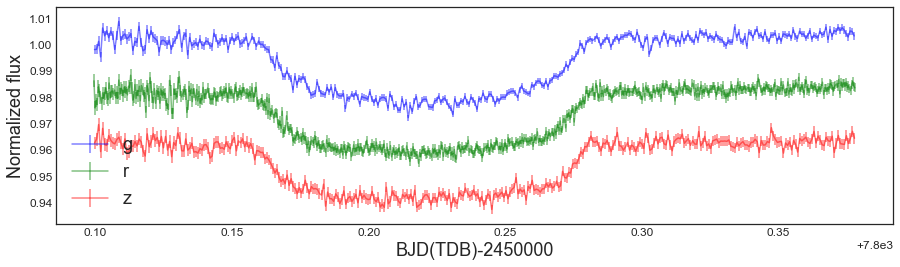

In [54]:
import matplotlib.pyplot as pl
%matplotlib inline

fluxcol =  'flux(r=11.0)'
errcol  =  'err_inflated' #'err(r=11.0)'

colors='b,g,r'.split(',')
fig,ax = pl.subplots(1,1,figsize=(15,4))

n=0
for b,c in zip(bands,colors):
    df = data[b]
    offset = n*0.02
    
    time = df.index
    flux = df[fluxcol]
    err  = df[errcol]
    
    ax.errorbar(time, flux-offset, yerr=err, label=b, color=c, alpha=0.5)
    ax.set_ylabel('Normalized flux', fontsize=fontsize)
    n+=1
pl.legend(loc='lower left', fontsize=fontsize)
pl.xlabel('BJD(TDB)-2450000', fontsize=fontsize)

Update uncertainty argument in logprob column

In [55]:
errs=[]
for b in bands:
    df=data[b]
    errs.append(df['err_inflated'])  

Re-evaluate `logprob` without `ldc_prior`:

In [56]:
logprob(full_params,
        time,
        flux,
        _P,
        color1,
        color2,
        dx,
        err,
        ldc_prior=None)

1909.7930474081666

In [57]:
logprob(full_params,
        time,
        flux,
        _P,
        color1,
        color2,
        dx,
        err,
        ldc_prior=ldc)

1914.0690196082714

# Appendix 

We can use multiprocessing to speed up emcee. See [doc](http://emcee.readthedocs.io/en/latest/tutorials/parallel/#multiprocessing) for example.

In [50]:
sampler.reset()

In [52]:
from multiprocessing import Pool
import time

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob, 
                                    args=args, pool=pool)
    start = time.time()
    sampler.run_mcmc(pos, nsteps1) #progress=True
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    #print("{0:.1f} times faster than serial".format(serial_time / multi_time))

Multiprocessing took 81.8 seconds


We can also use [schwimmbad](http://schwimmbad.readthedocs.io/en/latest/examples/index.html#using-mpipool) to speed up emcee.

In [51]:
import schwimmbad
schwimmbad.__version__

'0.3.0'